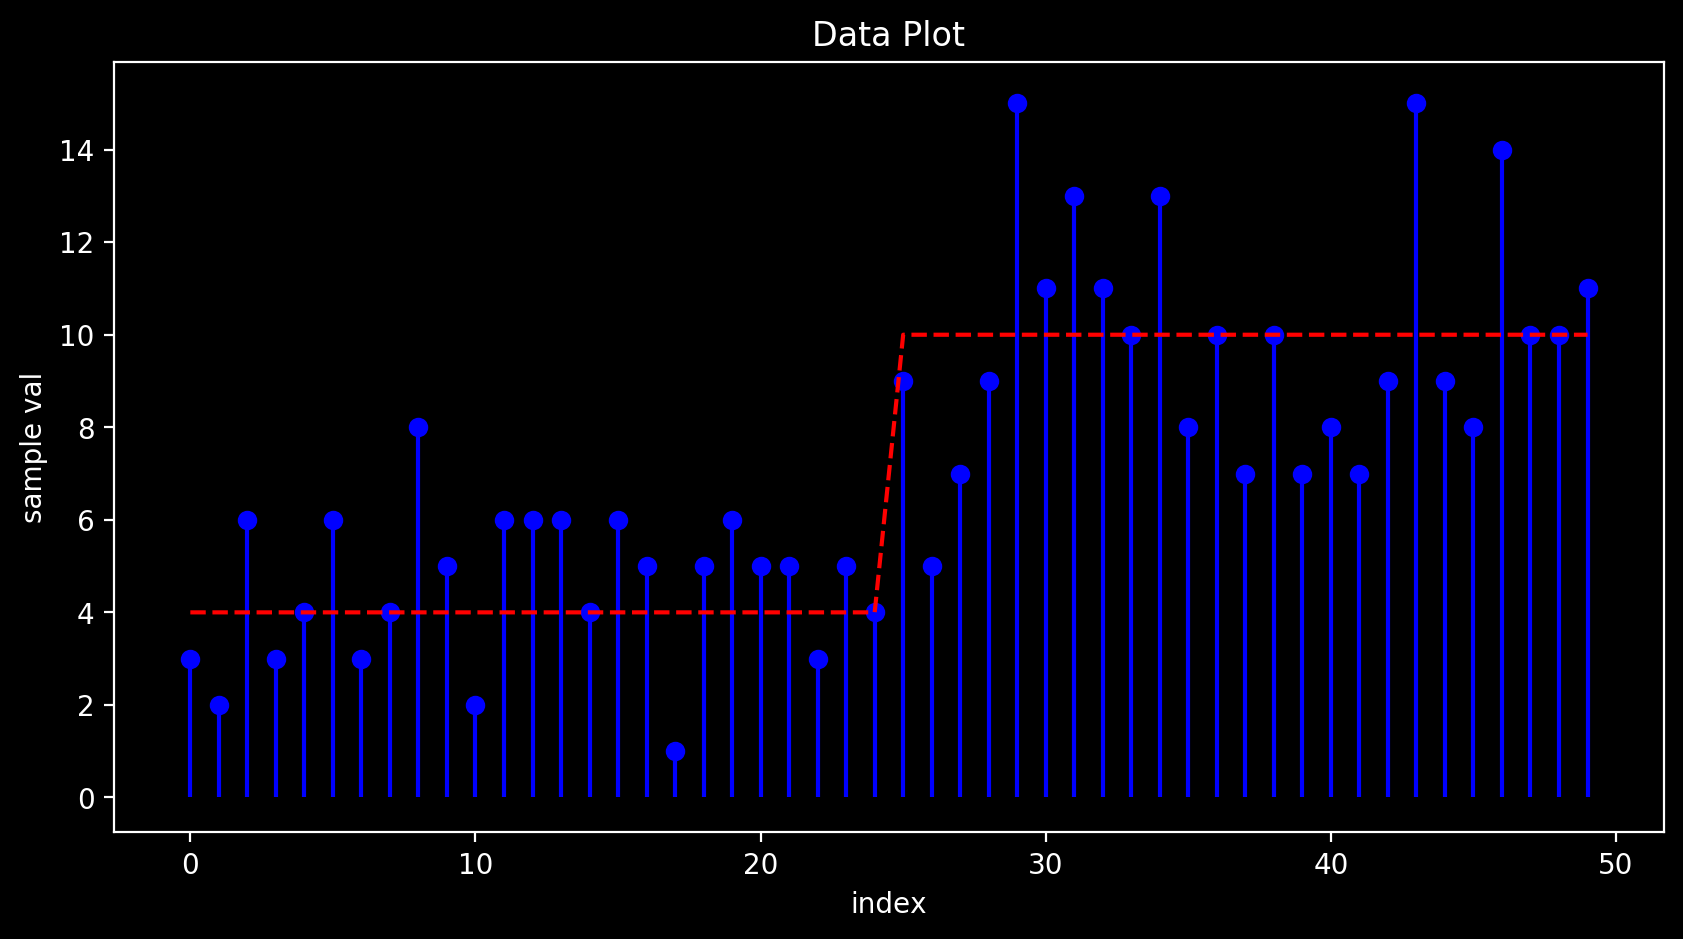

lam0     5.083618
lam1     8.121266
n       24.000000
dtype: float64


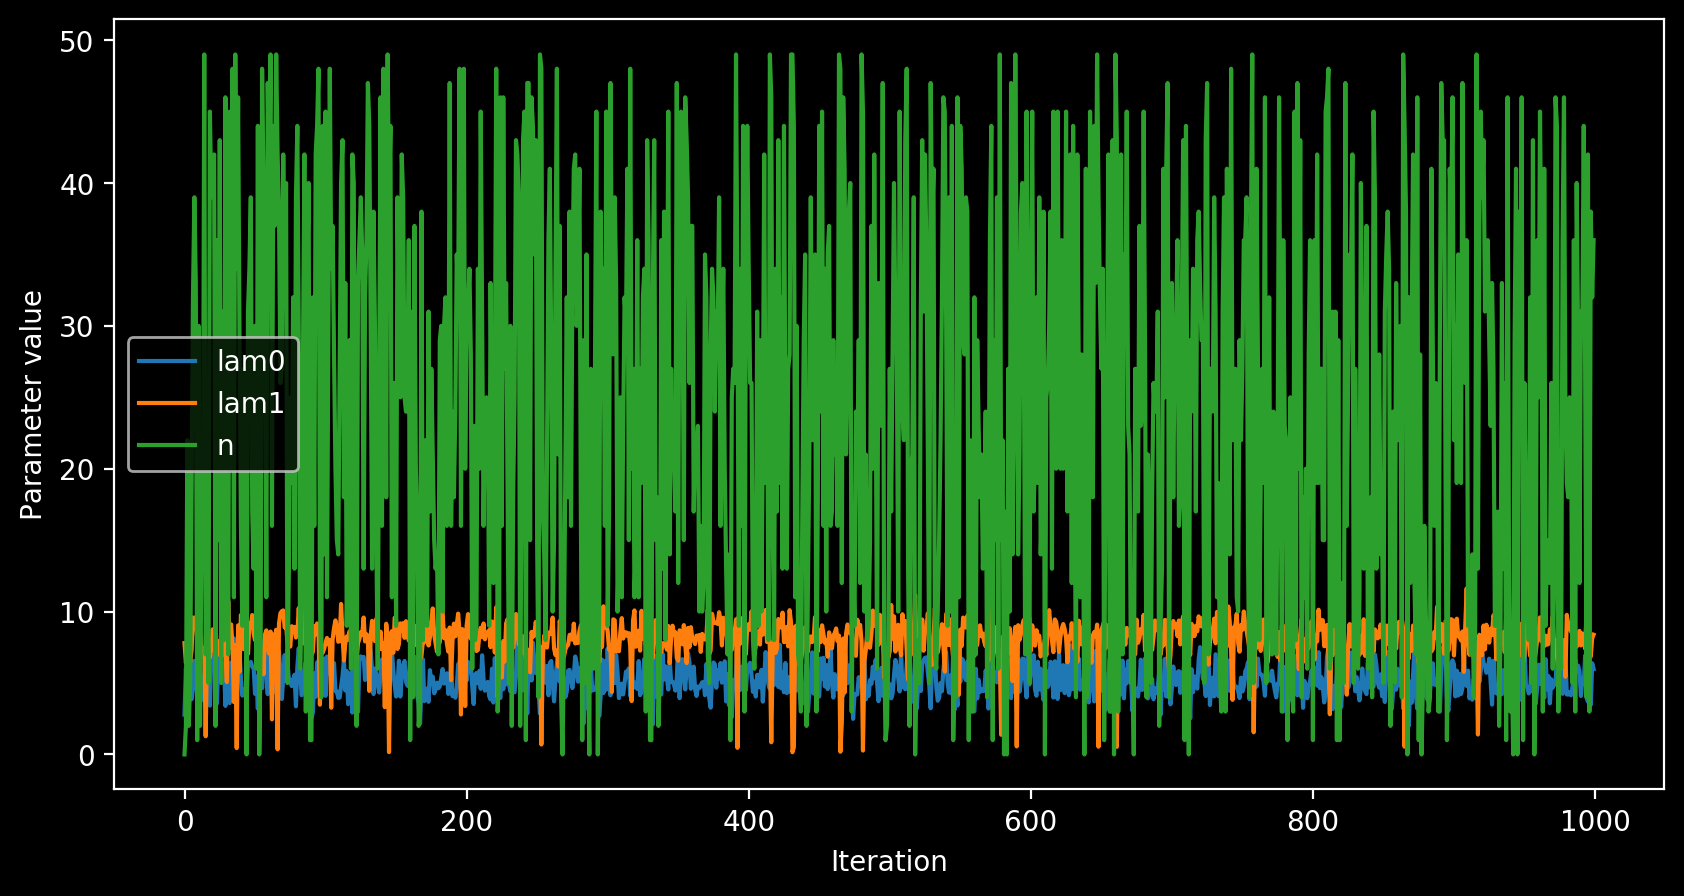

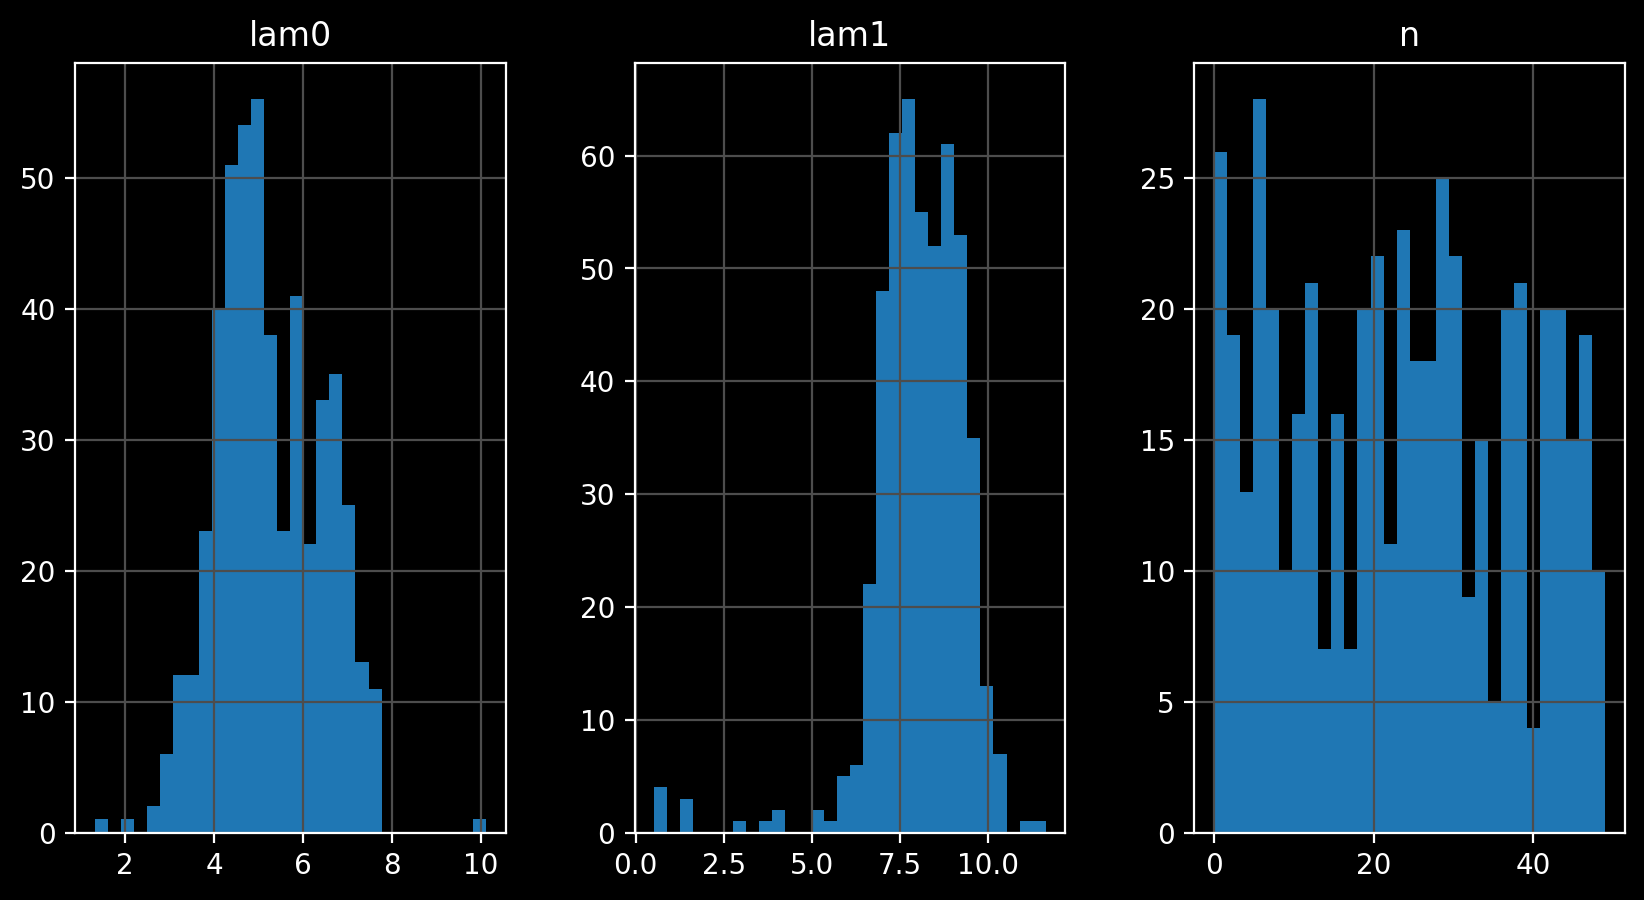

In [26]:
#proj7 Victor Zhang
#proj written on Juno on ios which does not support PYMC etc, hence packages not used
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (10, 5)
np.random.seed(767442)
#all 3 samplers defined as in paper
def sample_lambda0(x, n, a, b):
    k = np.sum(x[0:n+1]) + a
    sig = 1/(n+b)
    return np.random.gamma(k, sig)

def sample_lambda1(x, n, a, b):
    k = np.sum(x[n+1:]) + a
    sig = 1/(len(x)-n+b)
    return np.random.gamma(k, sig)
# draw from n by getting llh for each n and simulate by thresholding uniform random of max range
def sample_n(x, lambda0, lambda1):
    N = len(x)
    cache=np.zeros([N,1])
    for i in range(0,N):
        log_llh= np.sum(x[0:i+1])*np.log(lambda0)-i*lambda0+np.sum(x[i+1:])*np.log(lambda1)-(N-i)*lambda1
        #this part will introduce addictional noise to the process
        cache[i] = np.min((1,np.exp(log_llh)))/1000
        cache[i] += cache[i-1]
    draw = np.random.uniform(0, cache[-1])
    return np.sum(cache<draw)
#tie em together to one gibbs sampling process for this particular data set
def gibbs(y, x, iters, init, hypers):
    lam0 = init["lam0"]
    lam1 = init["lam1"]
    n = init["n"]

    trace = np.zeros((iters, 3)) ## keep track
    a = hypers["alpha"]
    b = hypers["beta"]
    for it in range(iters):
        lam0 = sample_lambda0(y, n, a, b)
        lam1 = sample_lambda1(y, n, a, b)
        n = sample_n(y, lam0, lam1)
        trace[it,:] = np.array((lam0, lam1, n))

    trace = pd.DataFrame(trace)
    trace.columns = ['lam0', 'lam1', 'n']
    return trace

#define hyper parameters
lam0_true = 4
lam1_true = 10
n_true = 25
N = 50
#generate data using similar parameters as the paper
x = np.arange(N)
y = np.concatenate((np.random.poisson(lam0_true,n_true), np.random.poisson(lam1_true, N-n_true)))
lvl = np.concatenate((np.ones([n_true,1])*lam0_true, np.ones([N-n_true,1])*lam1_true))
#plot the data
plt.vlines(x,np.zeros(y.shape),y,colors="blue")
plt.scatter(x,y,c="blue")
plt.plot(x,lvl,c="red",linestyle="--")
plt.xlabel("index")
plt.ylabel("sample val")
plt.title("Data Plot")
plt.show()



## specify initial values
init = {"lam0": 0,
        "lam1": 0,
        "n": 10}

## specify hyper parameters
hypers = {"alpha": 2,
          "beta": 1}

iters = 1000
trace = gibbs(y, x, iters, init, hypers)
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
trace_burnt = trace[500:iters]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))
print(trace_burnt.median())
#the median turns out close to the true param proving gibbs sampling worked as intended